 # Logistic regression with IVMax feature selection

In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
# import os.path
import rpy2
import scorecardpy as sc
from scorecardpy import info_value 
import seaborn as seabornInstance 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn import feature_selection
from sklearn.feature_selection import RFE, RFECV, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import descartes
import time

### Parameters to set

These parameters can be changed to affect feature selection and thus the accuracy of the model. They are at the beginning of the notebook to simplify the experimental process to identify optimal feature selection.

In [32]:
# NaN = 1 to drop NaN values in dataframe, else NaN = 0
NaN = 1

# correlated = 1 to drop correlated features in dataframe, else correlated = 0
correlated = 1

# correlation lower bound to drop features
corr_bound = 0.95

# minimum difference in IV to drop feature based on correlation bound
iv_diff = 0.1 #Feat_sum.loc[:,"Total_IV"].std()

### Reading in, cleaning, and selecting training data

In [33]:
# f = os.path.expanduser( "~/Documents/Vodacom/data/df_raw_final.pkl" )

df = pd.read_pickle('/home/samuel/Documents/Vacation work/env/df_raw_final.pkl')

In [4]:
#new dataframe after dropping all values with NaN
dfclean = df.dropna( subset = ['target_label'] )

#replace all strings "yes", "no", "maybe" with integers 0, 1, 2 
dfclean = dfclean.replace( to_replace = "yes", value = 1 )
dfclean = dfclean.replace( to_replace = "no", value = 0 )
dfclean = dfclean.replace( to_replace = "maybe", value = 2 )

# remove all rows with target_label = 2 ("maybe") as the model is built for binary logistic regression
dfclean = dfclean[ dfclean.target_label != 2 ]

# remove all columns that are targets 
for feature in dfclean :
    
    if (dfclean[feature].isna().sum() > 100) :
#         print(feature)
        dfclean = dfclean.drop( columns = feature )
        
# remove column geometry due to string error with conversion
dfclean_nogeo = dfclean.drop( columns = "geometry")

Column 'geometry' in dataframe causes unwanted errors.
Initialize new dataframe without the 'geometry' column.
Assumption that the 'geometry' column causes more issues than has relevance for model.

In [5]:
# add randomized feature

# dfclean_nogeo['randfeature'] = np.random.normal(size = dfclean_nogeo.shape[0])

In [6]:
# Split into training and testing data

dfclean_nogeo, df_test = train_test_split(dfclean_nogeo, test_size=0.3, random_state = 40)

We split before binning to avoid bias in setting bins according to testing data

### Identifying feature types

This section runs through all features in dfclean_nogeo in a for loop.
If the feature is a float or an integer, we check whether it is a code. If all instances in a feature are numeric and have the same length (ie cellphone numbers all have 10 digits) it is denoted as a code. This is done as follows:

The feature values are converted to a list, each value is converted to a string, the length of that string is added to a seperate list. That list is shortened to a set of its unique values. If all the values of the feature are the same length the length of that set is 1 and the feature is noted as a CODE. 

Features that are 'objects' or noted as a Code are saved as catagorical in a dictionary called Feat_typ, else they are saved as numeric. List of catagorical features and numeric features are both saved seperately and enumerated.


In [7]:
Feat_typ = {}
Num_typ = {}

num_list = []
cat_list = []
index_list = []

j = 1

# for loop to identify feature types

for i, feature in enumerate( dfclean_nogeo ):
    
    if ( dfclean_nogeo[ feature ].dtype == 'float64' or dfclean_nogeo[ feature ].dtype == 'int64'):
        
        value_list = dfclean_nogeo[feature].values
        length_values_list = []
        
# for loop identifying if all items in a given feature have the same number of characters
# if they do, identify feature as a category
        
        for item in value_list:
            
            length_values_list.append( len( str( item ) ) )

# CODE = true if number of characters in values of all features are the same            
            
        CODE = ( len( set( length_values_list ) ) == 1)
        
    if (dfclean_nogeo[feature].dtype == 'object' or CODE):     

        Feat_typ[feature] = [i,"cat"]
        index_list.append(feature)
        if (feature != 'target_label') :
            
            cat_list.append(feature)
    
    else:
        
        Feat_typ[feature] = [i, "num"]
        Num_typ[feature] = [j, "num"]
        num_list.append(feature)
        index_list.append(feature)
        j = j + 1
    
    # adding the 'target_label' column to num_list    
    
    if feature == "target_label":

        num_list.append( feature )


In [8]:
# cat_list

On investigation of this dataset, we decided not to use categorical feature for the model and dropped them:

In [9]:
# remove all columns that are targets or categories

dfclean_nogeo = dfclean_nogeo.drop( columns = cat_list )

df_test = df_test.drop( columns = cat_list )

### Binning and IV calculation

##### smbinning using R


Features are binned to improve model accuracy. After testing, smbinning proved to produce better IV values indicating better bins. smbinning is only written for R as Conditional Inference Trees dont seem to be possible in python yet. This section initially uses the package rpy2 to swap to R and perfrom the smbinning and return a list of the bins. The smbinning function cannot bin some of the features so only those features which are binned correctly are returned. We create a dictionary of these features and their respective cuts for binning. 

In [10]:
# Activates the use of R in the Jupyter Notebook
%load_ext rpy2.ipython

In [11]:
# # Brute force fix for kernel dying on Mac, Error15
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
%%R -i dfclean_nogeo -o cuts 

library(smbinning)
library(foreach)
library(doParallel)


comb <- function(...){
    mapply('cbind', ..., SIMPLIFY = FALSE)
}

no_cores <- detectCores()
registerDoParallel(cores = 4)

numg_list = c()
cutsgood = c()

Features <- names(dfclean_nogeo)[1:ncol(dfclean_nogeo)]

i = 1
j = 1

ptime <- system.time({

 cuts = foreach( col = Features, .combine = comb, .packages = 'smbinning')  %dopar%  {

    sbin = smbinning( dfclean_nogeo, 'target_label', col )
            
       if ( !is.na( sbin[ 'bands' ] ) ) {
        
            cutsgood[[i]] <- sbin$bands[ -length( sbin$bands ) ]
            numg_list[i] = col
            i = i + 1
           
        } 
     
        # adding target_label to numg_list
        if ( col == "target_label" ) {

            numg_list[i] = col

        }
     
     return(list(numg_list, cutsgood))
     
    }
    
})[3]
print(paste("Time taken for smbinning =", ptime, "seconds"))

R[write to console]: Loading required package: sqldf

R[write to console]: Loading required package: gsubfn

R[write to console]: Loading required package: proto

R[write to console]: Loading required package: RSQLite

R[write to console]: Loading required package: partykit

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: libcoin

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel



[1] "Time taken for smbinning = 6.705 seconds"


In [13]:
# Converting the R objects to a usable python dictionary

# create a list for numg_list from an R vector
cuts = list(cuts)

# creating dictionary of value cutsgood
cutsg_dic = dict( zip( cuts[0], cuts[1] ) )

##### WOE binning and IV calculation

The woebin function from the scorecardpy package creates IV tables for all numerical features in dataframe. We use smbinning's cut values for the bins for all numerical features within cutsg_dic, all other numerical features for which smbinning failed have bins cut by the woebin function. 
This is due to the assumption that smbinning's cut values for the bins will yielf a maximized IV while, woebinning's cut values will not be maximized.

In [36]:
# Weight of evidence (WOE) binning and information values calculation of all numerical features

num_iv = sc.woebin( dfclean_nogeo.loc[ :, num_list ],
                   y = "target_label", breaks_list = cutsg_dic, positive = 0, bin_num_limit = 20)

[INFO] creating woe binning ...


/home/samuel/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:725: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/home/samuel/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:725: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/home/samuel/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:725: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change

In [15]:
# # produce the plots of count distribution and bad probability for each bin for all features
# sc.woebin_plot(num_iv)

In [16]:
# Initialization of a new Dataframe called feature summary which includees each feature, 
# the number of unique and NaN values it has, and its IV

Feat_sum = pd.DataFrame( dfclean_nogeo.dtypes )

for feature in dfclean_nogeo:
    
    Feat_sum.loc[ feature,"Unique" ] = dfclean_nogeo[ feature ].nunique()
    Feat_sum.loc[ feature, "NaNs" ] = dfclean_nogeo[ feature ].isna().sum()
    
# adding iv values of numerical features to summary dataframe

for feature in dfclean_nogeo.loc[ :, num_list ]:
    
    if ( feature != 'target_label' ) :
        
        Feat_sum.loc[ feature,'Total_IV' ] = num_iv[ feature ].total_iv[ 1 ]

#### Correlation and NaN removal

If selected above, features which are highly correlated and which contain NaN values are removed. 

The threshold for removal based on correlation is set in the second block of the notebook. If two features are correlated above the threshold, the IV values of the features are check. the feature with the lowest IV value is removed. If the IV values are within the IV threshold set above, the features are added to a "check_list" and are not removed. Someone with domain experience can look at the pairs of features in the check list and remove the one they would prefer manually if so desired. This is done before woe transformation to save time. 

In [17]:
# creating correlation matrix
cor = dfclean_nogeo.corr()

# # Vsualization of feature correlation:
# cor.style.background_gradient(cmap = 'coolwarm')

# adding IV values to the correlation matrix
cor = cor.join(Feat_sum.Total_IV, how = 'outer')

In [18]:
rem_feat = []
check_feat = []

for feature, correl in cor.iteritems():
    
    #for each feature
    for i in np.arange(len(correl.values)):
    
    # run through each row of cor
        
        if (abs(correl[i]) > corr_bound and correl.index[i] != feature and feature != "Total_IV"):
    #if the correlation is high and less than one and ignore total IV
            
            if (cor.loc[correl.index[i], "Total_IV"] - cor.loc[feature, "Total_IV"] > iv_diff):
    #if the IV of the row feature is more than 0.1 greater than the IV of the column feature, 
    #add the column to the remove list
#                 print("row ",correl.index[i],"   is bigger than column     ", feature)
                rem_feat.append(feature)
            
            elif(cor.loc[correl.index[i], "Total_IV"] - cor.loc[feature, "Total_IV"] > 0):
    #if the features have very similar IVs, add them to the check list
                check_feat.append([feature, correl.index[i]])

rem_feat = list(dict.fromkeys(rem_feat))     #original order

#List of features to check:
#check_feat

In [19]:
# drop all rows containing NaN values 
if (NaN == 1):
    
    df_final_noNaN = dfclean_nogeo.dropna()
    df_test = df_test.dropna()
    
else:
        
    df_final_noNaN = dfclean_nogeo
    
# drop columns based off of correlation comparison
if (correlated == 1) :
    
    df_final_noNaN = df_final_noNaN.drop(columns = rem_feat)
    df_test = df_test.drop(columns = rem_feat)
    
    
# It makes a difference here that we drop na before correlated, but the effect is negligable.


##### WOE transformation

In [20]:
# transforming training data table to WOE values

df_final = sc.woebin_ply(df_final_noNaN, num_iv)

# transforming test data to WOE values

df_test_final = sc.woebin_ply(df_test, num_iv)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


### Feature selection using IVMax


Features are ordered in Feat_sum in decreasing order of their IV. There is some test manipulation so that feature names match after the woe transformation. 

The feature with the highest IV is selected and the model is run. The next feature is selected and the model is run again. If the accuracy improves, the feature is kept on the list of features to be used and the next feature is checked. If feature does not improve model accuracy it is skipped. The for loop runs throug all the features in Feat_sum so the model is run many times but it is very fast. 

In [21]:
for i, feat in enumerate(Feat_sum.iterrows()):
    Feat_sum = Feat_sum.rename(index = {feat[0]: feat[0] + "_woe"})
    

In [22]:
Feat_sum = Feat_sum.loc[df_final.columns]   #This simulates the corelation and NaN feature drop
Feat_sum = Feat_sum.sort_values("Total_IV", ascending = False)
Feat_sum.drop(Feat_sum.tail(1).index, inplace=True)

/home/samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [23]:
no_feat_acc_iv = []
best_feat = []
score2 = 0
nom_feat = 0
for no_feat in np.arange(len(Feat_sum)):
    
    new_feat = list(Feat_sum[no_feat:no_feat+1].index)
    used_feat = list(best_feat)
#     print("new = ", new_feat)
    used_feat.append(new_feat[0])
#     print("used = ", used_feat)
    X_train_iv = df_final.loc[:,used_feat]
    y_train_iv = pd.DataFrame(df_final.target_label)

    X_test_iv = df_test_final.loc[:,used_feat]
    y_test_iv = pd.DataFrame(df_test_final.target_label)
    
    logreg = LogisticRegression()
    logreg.fit(X_train_iv, y_train_iv)
    y_pred_iv = logreg.predict(X_test_iv)
    score1 = logreg.score(X_test_iv, y_test_iv)
#     print(score1)
    if (score1 > score2) :
        score2 = score1
        nom_feat = nom_feat + 1
        best_feat.append(new_feat[0])
        no_feat_acc_iv.append([score2, nom_feat, used_feat])
#     print("best = ", best_feat)

/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib

/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib

/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/samuel/anaconda3/lib

In [24]:
print("Model accuracy = ", max(no_feat_acc_iv)[0],
     "\nNumber of features = ", max(no_feat_acc_iv)[1],
     "\n\nFeature selected = ", max(no_feat_acc_iv)[2])

Model accuracy =  0.8736176935229067 
Number of features =  9 

Feature selected =  ['computer_perc_woe', 'AREA_KM2_woe', 'P_NLI1_woe', 'D_DOMESTIC_KM2_woe', 'dvd_perc_woe', 'r_2_457_601_or_more_woe', 'HH_NLI1_woe', 'r_1___r_4800_woe', 'AGE60_64_woe']


### PREDICTIONS

Predictions for all 103576 EAs using the model trained on the original training set

In [25]:
# List of features selected, 2 different lists as feature names change after woe transformation
used_feat_woe = max(no_feat_acc_iv)[2]
used_feat = [feature.replace('_woe', '') for feature in used_feat_woe]

In [26]:
# reducing the database to only those features needed, saves 50 seconds
X_pred_iv = df.loc[:,used_feat]

In [27]:
# transforming data into woe values
X_pred_iv_woe = sc.woebin_ply(X_pred_iv, num_iv)

[INFO] converting into woe values ...


In [28]:
# Training the model

X_train_iv = df_final.loc[:,used_feat_woe]
y_train_iv = pd.DataFrame(df_final.target_label)
logreg = LogisticRegression()
logreg.fit(X_train_iv, y_train_iv)

# Making predictions

y_pred_iv = logreg.predict(X_pred_iv_woe)

/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/samuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
map_df = pd.DataFrame(df.geometry)
map_df['Fibre_prediction'] = y_pred_iv
# ma = map_df[map_df.target_level == 1]   #count number of yes predicitons
mapp = geopandas.GeoDataFrame(map_df)

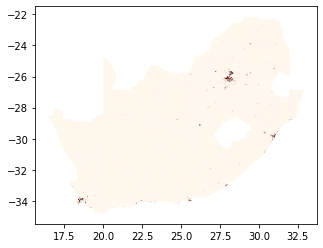

In [30]:
mapp.plot(column = 'Fibre_prediction', cmap = 'OrRd')